<h1>Random Forest Classifier - Respondents 1 & 3 </h1>

<h2>Data Exploration</h2>

Number of NaN values in 'Cognitive Task' column:  0


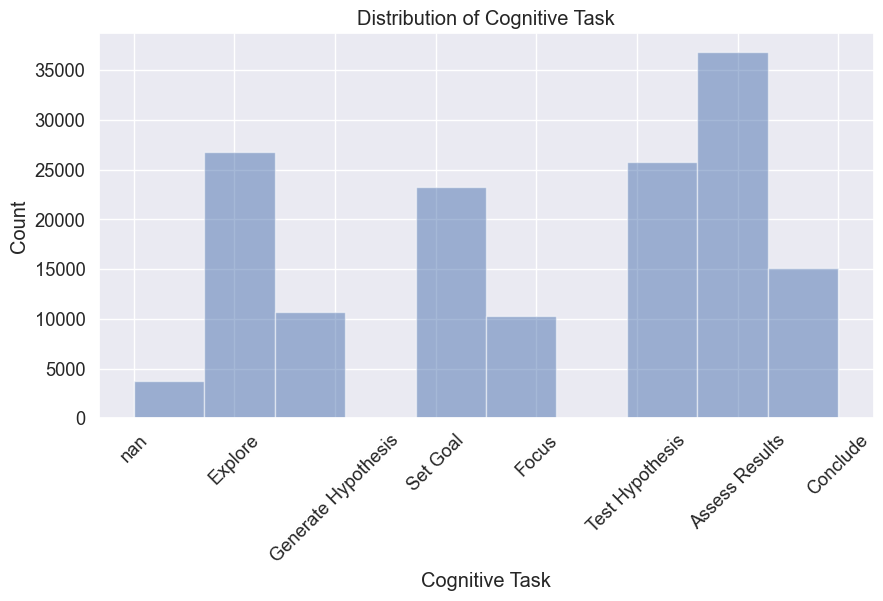

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
file_path = '001-b45731a0_emotions_with_cognitive_task_and_screen.csv'
data = pd.read_csv(file_path)

# Load the second CSV file
new_file_path = '003-91dc3428_emotions_with_cognitive_task_and_screen.csv'
new_data = pd.read_csv(new_file_path)

# Merge the two dataframes
data = pd.concat([data, new_data])

def showCognitiveTaskDistribution(data):

    # Convert the Cognitive Task column to a string type
    data['Cognitive Task'] = data['Cognitive Task'].astype(str)

    # Count the number of NaN values in the Cognitive Task column
    nan_count = data['Cognitive Task'].isna().sum()

    # Print the result
    print("Number of NaN values in 'Cognitive Task' column: ", nan_count)

    # Create a wider figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Create a histogram of the Cognitive Task column
    plt.hist(data['Cognitive Task'], alpha=0.5)

    # Add labels and title
    plt.xlabel('Cognitive Task')
    plt.ylabel('Count')
    plt.title('Distribution of Cognitive Task')

    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    # Show the plot
    plt.show()

showCognitiveTaskDistribution(data)


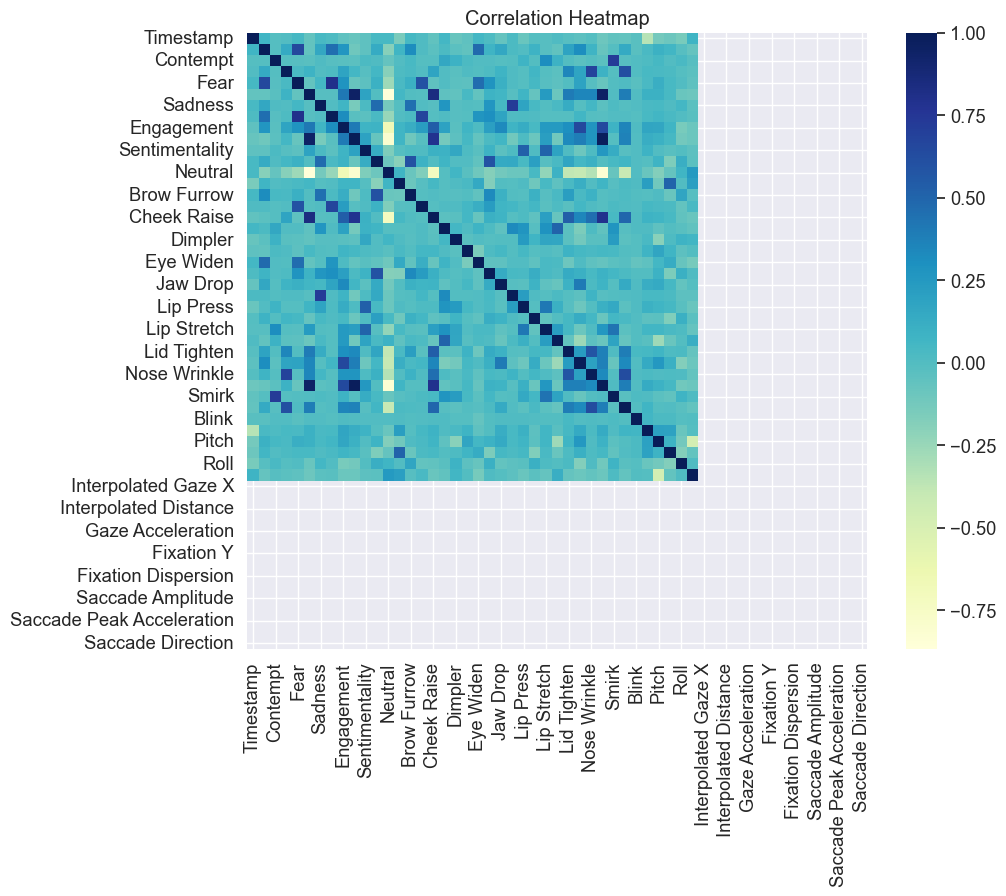

In [57]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix as a heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

<h2>Pre-processing</h2>

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the CSV file
file_path = '001-b45731a0_emotions_with_cognitive_task_and_screen.csv'
data = pd.read_csv(file_path)

# Load the second CSV file
new_file_path = '003-91dc3428_emotions_with_cognitive_task_and_screen.csv'
new_data = pd.read_csv(new_file_path)

# Merge the two dataframes
data = pd.concat([data, new_data])

# Drop the Timestamp column
data = data.drop('Timestamp', axis=1)

# Remove columns with all NaN values
data = data.dropna(axis=1, how='all')

# Drop rows with NaN values in the target column
data = data.dropna(subset=['Cognitive Task'])
print(data.head())

# Identify numeric and categorical features, excluding the target variable
all_columns = data.columns.tolist()
target_column = 'Cognitive Task'
all_columns.remove(target_column)
numeric_features = data[all_columns].select_dtypes(include=['int64', 'float64']).columns
categorical_features = data[all_columns].select_dtypes(include=['object']).columns


# Exclude the target column from the numeric features
numeric_features = numeric_features.drop('Cognitive Task', errors='ignore')

# Define the preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine the preprocessing steps into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data
y = data['Cognitive Task']
X = data.drop('Cognitive Task', axis=1)
X_preprocessed = preprocessor.fit_transform(X)

# Get the transformed feature names for the categorical columns
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine the numeric and transformed categorical feature names
all_feature_names = list(numeric_features) + list(cat_feature_names)

# Convert the preprocessed data back to a DataFrame
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_feature_names)

# Reset the index of y
y.reset_index(drop=True, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


         Anger  Contempt   Disgust      Fear       Joy   Sadness  Surprise  \
3705  0.117002  0.136948  0.021518  0.116770  0.041248  0.112264  0.059114   
3706  0.131634  0.137617  0.021531  0.132963  0.040812  0.112249  0.067522   
3707  0.164536  0.137096  0.021582  0.169795  0.040925  0.111568  0.087434   
3708  0.207359  0.136868  0.021714  0.218535  0.041063  0.111219  0.114075   
3709  0.240224  0.137239  0.021806  0.256706  0.040785  0.110944  0.135015   

      Engagement  Valence  Sentimentality  ...  Smirk  Upper Lip Raise  Blink  \
3705    0.328766      0.0        0.976782  ...    0.0         0.006627    0.0   
3706    0.328766      0.0        0.911952  ...    0.0         0.007317    0.0   
3707    0.328766      0.0        0.831274  ...    0.0         0.014862    0.0   
3708    0.328766      0.0        0.829263  ...    0.0         0.019549    0.0   
3709    0.328766      0.0        0.773583  ...    0.0         0.020340    0.0   

      BlinkRate     Pitch       Yaw      Rol

<h2>Random Forest Classifier</h2>

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

    
# Define the class weights based on the class distribution
class_weights = {
    'Assess Results': 0.5,  # Assess Results - weight for class 0 (majority class)
    'Conclude': 1.5,  # Conclude - weight for class 1 (minority class)
    'Explore': 1.0,  # Explore - weight for class 2 (majority class)
    'Focus': 2.0,  # Focus - weight for class 3 (minority class)
    'Generate Hypothesis': 2.0,  # Generate Hypothesis - weight for class 4 (minority class)
    'Set Goal': 1.0,  # Set Goal - weight for class 5 (majority class)
    'Test Hypothesis': 1.0  # Test Hypothesis - weight for class 6 (majority class)    
}

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Plot the feature importance
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Feature Importance')
plt.show()


<h3> With Recursive Feature Elimination (RFE) </h3>

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE to select the top k features
k = 5  # Number of features to select
rfe = RFE(estimator=model, n_features_to_select=k, step=1)
rfe.fit(X_train, y_train)

# Transform the train and test datasets using the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the model on the transformed training data
model.fit(X_train_rfe, y_train)

# Test the model
y_pred = model.predict(X_test_rfe)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))



TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'missing_values'

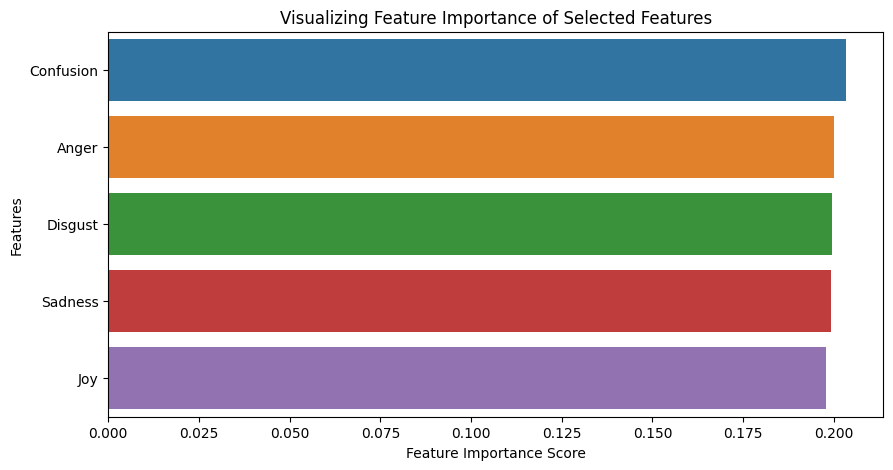

In [14]:
# Define all_feature_names based on the column names of your DataFrame
all_feature_names = X_train.columns

# Plot the feature importance of the selected features
importances = model.feature_importances_
selected_feature_indices = np.where(rfe.support_)[0]
selected_feature_names = all_feature_names[selected_feature_indices]
feature_importances = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Feature Importance of Selected Features')
plt.show()

In [13]:
from sklearn.model_selection import cross_val_score

# Use 5-fold cross-validation to evaluate the model
cv_scores = cross_val_score(model, X_preprocessed, y, cv=5)
print("Average cross-validation score:", np.mean(cv_scores))


Average cross-validation score: 0.4517843080538805


<h2>Perform Prediction on Respondent 2</h2>

In [29]:
import pandas as pd

# Set the low_memory parameter to False
df = pd.read_csv('002_a2da21a1-data-for-prediction.csv', low_memory=False)


# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Fill missing values in numeric columns with the mean
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

print(df.shape[0])

df_selected = df.loc[:, selected_feature_names]

# Reset the index of y
y.reset_index(drop=True, inplace=True)

predictions = model.predict(df_selected)

df['predictions'] = predictions
df.to_csv('resp_2_predictions.csv', index=False)



36089


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
